Change  `fold` and `file1` accordingly and run all the cells. The code will place a .csv with the abundances, errors, and locations in the same fold as where your fits file was.

In [3]:
# some of the usual imports
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
fold = "/mnt/c/Users/roark/Documents/"
file1 = "allStarCannon-l31c.2.fits"
file2 = "allStar-l31c.2.fits"
#CWD = os.getcwd()
#if os.path.exists("data/allStarCannon-l31c.2.fits"):
#    DATA_DIR = os.path.join(CWD, "data")
#else:
#    DATA_DIR = CWD
#    
#file1 = "allStarCannon-l31c.2.fits"
#hdu_list = fits.open(os.path.join(DATA_DIR, file1))
    
hdu_list = fits.open(fold+file1)
abun_data = Table(hdu_list[1].data)


In [5]:
hdu_list2 = fits.open(fold+file2)
vel_data = Table(hdu_list2[1].data)

In [38]:
cols = abun_data.colnames
myCols = []
myColNames = ["RA_HRS","DEC_DEG"]
for i in range(len(cols)):
    if not ("RAW" in str(cols[i])):
        if ("_H" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))
        elif ("TEFF" in str(cols[i])) or ("LOGG" in str(cols[i])) or ("_M" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))

myColNames.append('RAD_VEL')
myColNames.append('RAD_VEL_ERR')

In [39]:
print(myColNames)

['RA_HRS', 'DEC_DEG', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'FE_H', 'C_H', 'CI_H', 'N_H', 'O_H', 'NA_H', 'MG_H', 'AL_H', 'SI_H', 'P_H', 'S_H', 'K_H', 'CA_H', 'TI_H', 'TIII_H', 'V_H', 'CR_H', 'MN_H', 'CO_H', 'NI_H', 'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR', 'FE_H_ERR', 'C_H_ERR', 'CI_H_ERR', 'N_H_ERR', 'O_H_ERR', 'NA_H_ERR', 'MG_H_ERR', 'AL_H_ERR', 'SI_H_ERR', 'P_H_ERR', 'S_H_ERR', 'K_H_ERR', 'CA_H_ERR', 'TI_H_ERR', 'TIII_H_ERR', 'V_H_ERR', 'CR_H_ERR', 'MN_H_ERR', 'CO_H_ERR', 'NI_H_ERR', 'RAD_VEL', 'RAD_VEL_ERR']


In [40]:

ii = (abun_data['FILENAME'] != '')

print(len(abun_data['APOGEE_ID']))
print(len(abun_data['APOGEE_ID'][ii]))
print(len(abun_data['APOGEE_ID'][ii])/len(abun_data['APOGEE_ID']))

#can parse ratios by error

277371
164074
0.5915326403985998


In [42]:
myArr = np.array(abun_data[:][ii])
newArr = np.zeros([len(abun_data[:][ii]),len(myCols)+4],)
print(len(myArr))
print(newArr.shape)
locArr = np.array(vel_data['APOGEE_ID'][1:])
radArr = np.array(vel_data['VHELIO_AVG'][1:])
radErrArr = np.array(vel_data['VERR'][1:])

164074
(164074, 52)


In [43]:
i=0
l1=0

for i in range(len(myArr)):
    myrow = myArr[i]
    
    #Parse RA
    locStr = myrow[0]
    raStr = locStr[2:10]
    hrs = int(raStr[0:2])
    mins = int(raStr[2:4])
    secs = int(raStr[4:6])+ int(raStr[6:8])/100.0
    ra = hrs+mins/60.0+secs/3600.0

    #print(i)
    #Parse Dec
    decStr = locStr[10:]

    if decStr[0] == "+":
        decSgn = 1.0
    else:
        decSgn = -1.0
    deg = int(decStr[1:3])*decSgn
    arcMins = int(decStr[3:5])*decSgn
    arcSecs = (int(decStr[5:7])+int(decStr[7])/10.0)*decSgn
    dec = deg+arcMins/60.0+arcSecs/3600.0
    #print(dec)

    #Save RA and Dec
    newArr[i,:2] = [ra,dec]

    ##Get Rad velocity
    ind = -1

    for l in range(l1,len(locArr)):
        if locArr[l]  == locStr:
            ind = l
            l1 = l
            #locArr = np.delete(locArr,np.arange(0,l))
            break
    newArr[i,-2] = radArr[ind]
    newArr[i,-1]= radErrArr[ind]
        #radArr = np.delete(radArr,np.arange(0,l))
        #radErrArr = np.delete(radErrArr,np.arange(0,l))


    #Save Abundance Values
    k=0
    for j in myCols:
        colNom = myColNames[2+k]
        val=0.0
        if (colNom == "NA_H_ERR"):
            valInd = 2+k-23
            if (newArr[i,valInd]<=-100.0):
                newArr[i,valInd] = np.nan
                val=np.nan
            else:
                val=myrow[j]

        if ("_ERR" in colNom) and (myrow[j] >=1) and not ("TEFF" in colNom):
            val = np.nan
            valInd = 2+k-23
            newArr[i,valInd]=np.nan

        else:
            val = myrow[j]

        newArr[i,2+k] = val
        k+=1
    perc = i/len(myArr)
    if int(i/20000.0) == i/20000.0:
        print(perc)



0.0
0.1218962175603691
0.2437924351207382
0.3656886526811073
0.4875848702414764
0.6094810878018455
0.7313773053622146
0.8532735229225837
0.9751697404829528


In [44]:
print(newArr.shape)
print(len(myColNames))


(164074, 52)
52


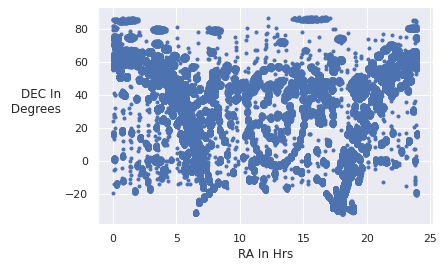

In [45]:
plt.plot(newArr[:,0],newArr[:,1],'.')
plt.xlabel("RA In Hrs")
plt.ylabel("DEC In\n Degrees",rotation=0,ha='right')
plt.show()

In [46]:
saveFile = fold+"Cannon.csv"
headStr = ""
for entry in myColNames:
    headStr += entry
    headStr += ','
np.savetxt(saveFile,newArr,delimiter=',',fmt="%1.8e",header=headStr,comments='')

In [47]:
#How to load the csv into a data dictionary
myArr = np.loadtxt(saveFile,delimiter=',',skiprows=1)
headArr = np.loadtxt(saveFile,delimiter=',',max_rows=1,dtype=str)
data = {}
for i in range(len(headArr)-1):
    data[headArr[i]] = myArr[:,i]


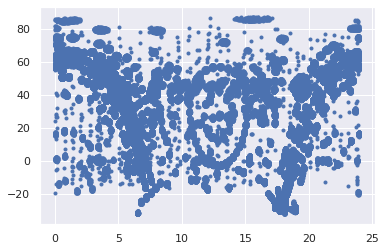

In [48]:

plt.plot(data["RA_HRS"],data["DEC_DEG"],'.')